# Ejemplo de clasificador con el dataset Titanic

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Configuración para reproducibilidad
RANDOM_STATE = 42

### 1. Cargar datos y análisis exploratorio

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
print("=== Información del dataset ===")
print(f"Dimensiones: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

=== Información del dataset ===
Dimensiones: (891, 12)
Columnas: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [4]:
print(f"\nTipos de datos:\n{df.dtypes}")


Tipos de datos:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [5]:
print(f"\nValores faltantes:\n{df.isnull().sum()}")


Valores faltantes:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


No sobrevivieron: 549 (61.6%)
Sobrevivieron:     342 (38.4%)


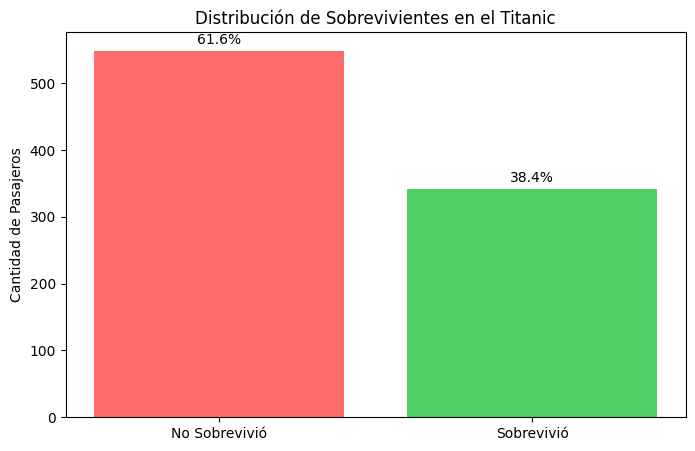

In [6]:
# Análisis de la variable objetivo
survived_counts = df['Survived'].value_counts()
survived_percent = df['Survived'].value_counts(normalize=True) * 100

print(f"No sobrevivieron: {survived_counts[0]} ({survived_percent[0]:.1f}%)")
print(f"Sobrevivieron:     {survived_counts[1]} ({survived_percent[1]:.1f}%)")

plt.figure(figsize=(8, 5))
plt.bar(['No Sobrevivió', 'Sobrevivió'], survived_counts.values, 
        color=['#ff6b6b', '#51cf66'])
plt.title('Distribución de Sobrevivientes en el Titanic')
plt.ylabel('Cantidad de Pasajeros')
plt.text(0, survived_counts[0] + 10, f'{survived_percent[0]:.1f}%', ha='center')
plt.text(1, survived_counts[1] + 10, f'{survived_percent[1]:.1f}%', ha='center')
plt.show()

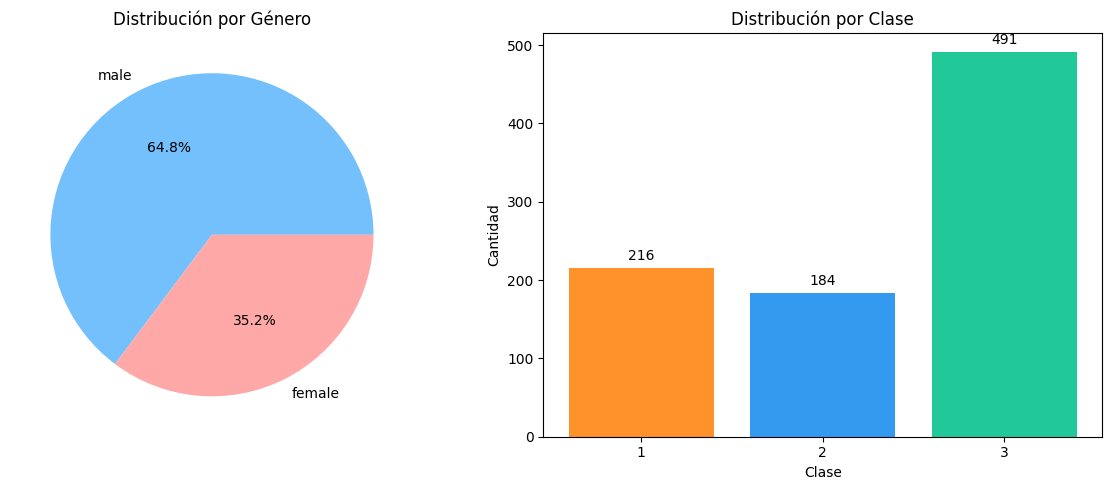

In [7]:
# Distribución por género y clase
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
gender_counts = df['Sex'].value_counts()
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
        colors=['#74c0fc', '#ffa8a8'])
plt.title('Distribución por Género')

plt.subplot(1, 2, 2)
class_counts = df['Pclass'].value_counts().sort_index()
plt.bar(class_counts.index.astype(str), class_counts.values, 
        color=['#ff922b', '#339af0', '#20c997'])
plt.title('Distribución por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 10, str(count), ha='center')

plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

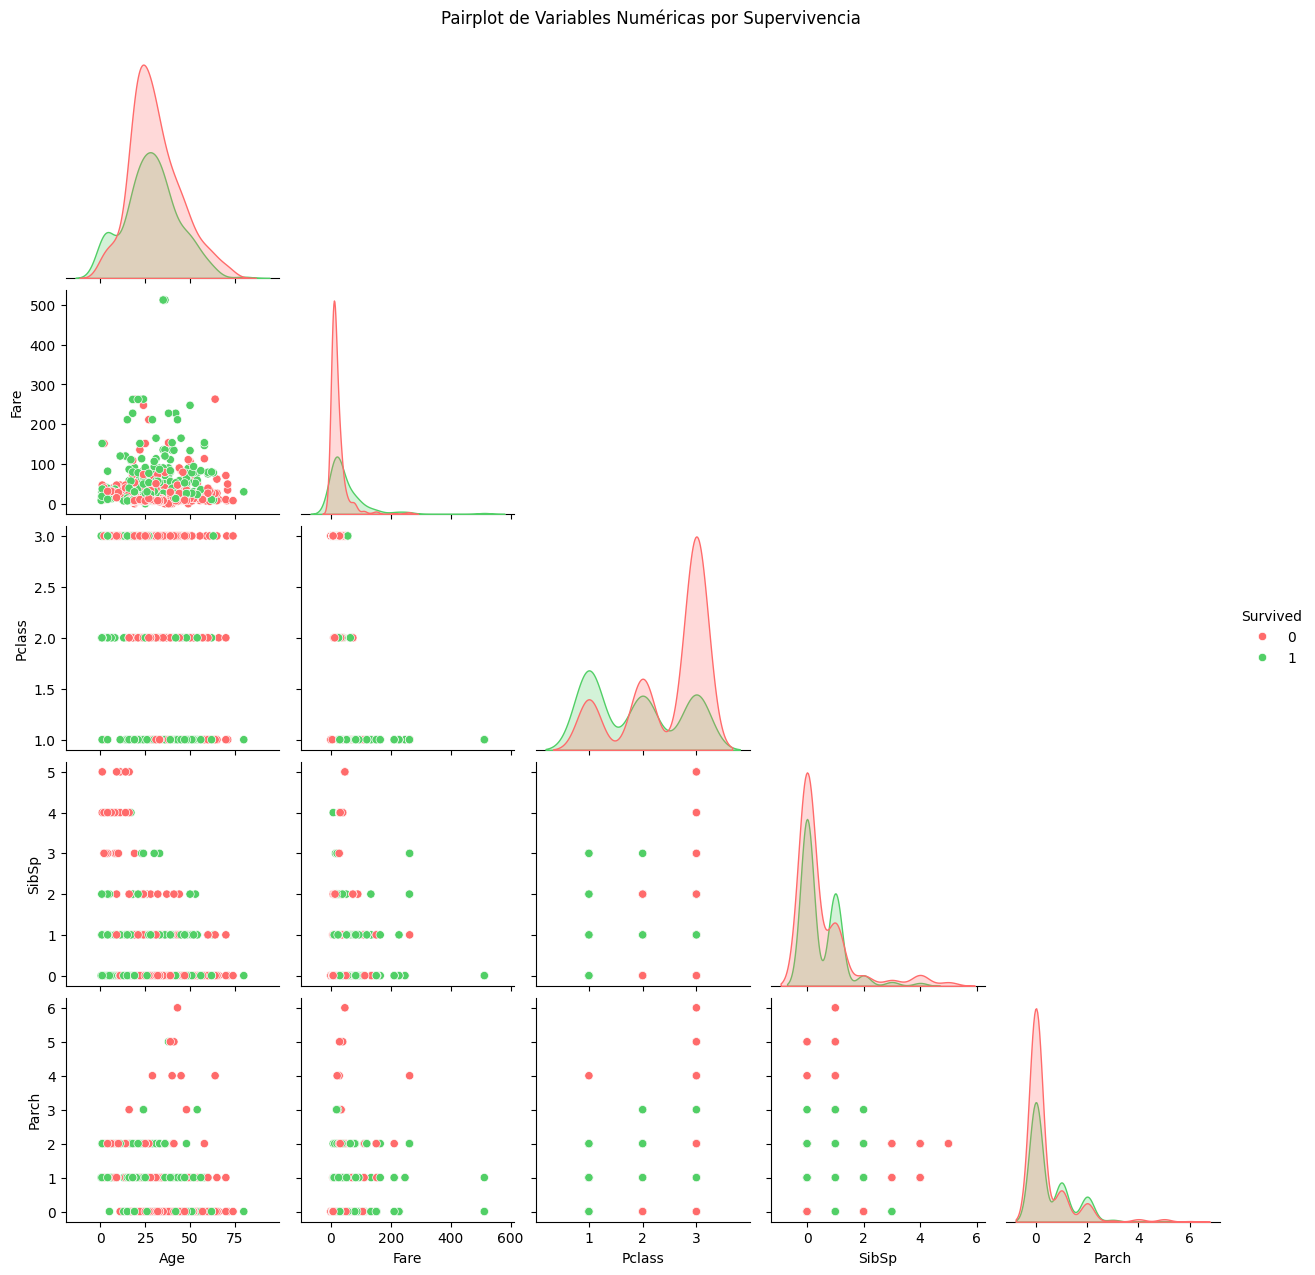

In [8]:
# Pairplot de variables numéricas más importantes
numeric_vars = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'Survived']
pairplot_df = df[numeric_vars].dropna()

plt.figure(figsize=(10, 8))
sns.pairplot(pairplot_df, hue='Survived', palette={0: '#ff6b6b', 1: '#51cf66'}, 
             diag_kind='kde', corner=True)
plt.suptitle('Pairplot de Variables Numéricas por Supervivencia', y=1.02)
plt.show()

### 2. Procesamiento de los datos

In [9]:
df_model = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].dropna()
df_model['Sex'] = df_model['Sex'].map({'male': 0, 'female': 1})

print(f"Tamaño después de limpieza: {df_model.shape}")
print(f"Distribución final:\n{df_model['Survived'].value_counts()}")

Tamaño después de limpieza: (714, 7)
Distribución final:
Survived
0    424
1    290
Name: count, dtype: int64


### 3. Partición de los datos (80/20 estratificada)

In [10]:
X = df_model[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y = df_model['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

### 4. Entrenamiento del modelo

In [11]:
model = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, max_depth=3)
model.fit(X_train, y_train) # Aquí ocurre la magia: training!

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

### 5. Evaluación del modelo

=== MATRIZ DE CONFUSIÓN ===


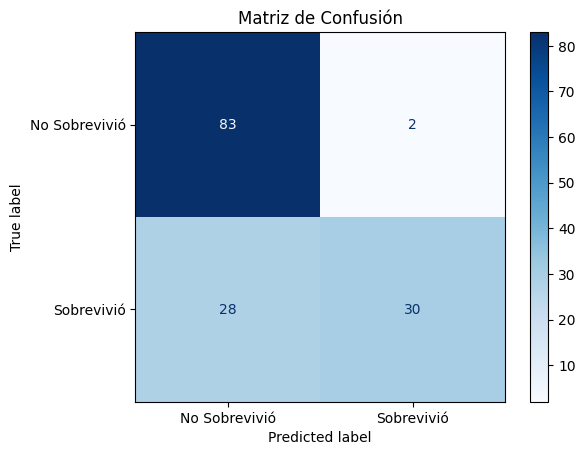

In [12]:
y_pred = model.predict(X_test) # Aquí ocurre otra magia: testing!
y_prob = model.predict_proba(X_test)[:, 1] # solo para AUC
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("=== MATRIZ DE CONFUSIÓN ===")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Sobrevivió', 'Sobrevivió'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

### 6. Estimación de métricas

In [13]:
# Métrica global
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("\n=== Métrica global ===")
print(f"Accuracy Global: {accuracy:.4f}")

# Métricas para clase 0 (No sobrevivientes)
sensibilidad_clase0 = tn / (tn + fp) if (tn + fp) > 0 else 0
especificidad_clase0 = tp / (tp + fn) if (tp + fn) > 0 else 0
precision_clase0 = tn / (tn + fn) if (tn + fn) > 0 else 0
f1_clase0 = 2 * (precision_clase0 * sensibilidad_clase0) / (precision_clase0 + sensibilidad_clase0) if (precision_clase0 + sensibilidad_clase0) > 0 else 0

# Métricas para clase 1 (Sobrevivientes)
sensibilidad_clase1 = tp / (tp + fn) if (tp + fn) > 0 else 0
especificidad_clase1 = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_clase1 = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_clase1 = 2 * (precision_clase1 * sensibilidad_clase1) / (precision_clase1 + sensibilidad_clase1) if (precision_clase1 + sensibilidad_clase1) > 0 else 0

metrics_table = pd.DataFrame({
    'Métrica': ['TPR', 'TNR', 'PPV', 'F1-Score'],
    'Clase 0 (No sobrevivientes)': [
        f'{sensibilidad_clase0:.3f}',
        f'{especificidad_clase0:.3f}', 
        f'{precision_clase0:.3f}',
        f'{f1_clase0:.3f}'
    ],
    'Clase 1 (Sobrevivientes)': [
        f'{sensibilidad_clase1:.3f}',
        f'{especificidad_clase1:.3f}',
        f'{precision_clase1:.3f}',
        f'{f1_clase1:.3f}'
    ]
})

print("\n=== Métricas por clase ===")
print(metrics_table.to_string(index=False))


=== Métrica global ===
Accuracy Global: 0.7902

=== Métricas por clase ===
 Métrica Clase 0 (No sobrevivientes) Clase 1 (Sobrevivientes)
     TPR                       0.976                    0.517
     TNR                       0.517                    0.976
     PPV                       0.748                    0.938
F1-Score                       0.847                    0.667


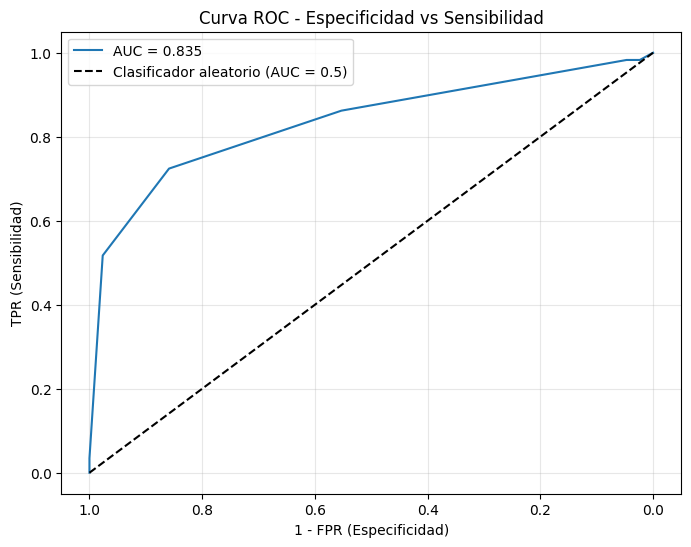

In [14]:
# Graficar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
fpr_inv = 1 - fpr

plt.figure(figsize=(8, 6))
plt.plot(fpr_inv, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([1, 0], [0, 1], 'k--', label='Clasificador aleatorio (AUC = 0.5)')
plt.xlabel('1 - FPR (Especificidad)')  # Eje X: Especificidad
plt.ylabel('TPR (Sensibilidad)')
plt.title('Curva ROC - Especificidad vs Sensibilidad')
plt.gca().invert_xaxis()  # Invertir eje X: 1 → 0
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()